# Finding Topics in News Article

Salah satu kegunaan dari machine learning pada media adalah untuk membantu membawakan konten media ke pengguna atau pembaca. Hal ini biasanya dalam bentuk rekomendasi konten, newsfeed, atau kategori konten yang sesuai dengan minat pengguna atau pembaca. Pada project kali ini, akan dicari topik-topik bahasan pada artikel berita yang diterbitkan olen **New York Times** menggunakan **unsupervised machine learning**.

## Import Libraries

Ada beberapa library yang perlu anda install seperti library `contractions` digunakan untuk menampilkan kata utuh dari kalimat yang terdapat slang/singkatan seperti `you'll -> you will, A.S.A.P -> as soon as possible`. anda dapat mengintall menggunakan `$ pip install contractions`. Anda juga perlu menginstall library nltk menggunakan anaconda prompt dengan `conda install -c anaconda nltk`.

In [3]:
!pip install contractions

     |████████████████████████████████| 321 kB 9.1 MB/s 
     |████████████████████████████████| 284 kB 37.9 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85448 sha256=61f22a2287dde52d33187f2693b4d093824d730a103e34f62b0c95e2bf6aa3df
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns

import re
import string
import contractions
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage


from datetime import datetime

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Dataset

`nyt-articles-2020.csv.zip` (`nyt-articles-2020.csv`), yaitu dataset artikel terbitan *new york times* sepanjang tahun 2020 sejumlah **16K+** **artikel** dengan **11 fitur**:

    - `newsdesk` - Article news desk
    - `section` - Article section
    - `subsection` - Article subsection
    - `material` - Type of material
    - `headline` - Headline
    - `abstract` - Abstract
    - `keywords` - Keywords
    - `word_count` - Total article length
    - `pub_date` - Date of publication
    - `n_comments` - Number of comments
    - `uniqueID` - Article unique identifier

In [5]:
df_articles = pd.read_csv("data/nyt-articles-2020.csv")

In [6]:
df_articles

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...
...,...,...,...,...,...,...,...,...,...,...,...
16782,Editorial,Opinion,NaN,Op-Ed,What It Takes to Heal From Covid-19,"Survivors can get better, but they need help.","['Chronic Condition (Health)', 'Coronavirus (2...",1002,2020-12-31 15:27:47+00:00,166,nyt://article/e8adbb75-a8b3-5a8c-886b-b9c1195f...
16783,Sports,Sports,Baseball,News,Padres Jolt M.L.B. With Bold Moves to Set Up W...,While many teams continued to assess the finan...,"['San Diego Padres', 'Major League Baseball', ...",1100,2020-12-31 15:47:44+00:00,42,nyt://article/1f11417d-2c57-51b9-b75d-8f67f0a9...
16784,Business,Business Day,NaN,News,"Their Finances Ravaged, Customers Fear Banks W...",Banks have the power to decide whether to let ...,"['Banking and Financial Institutions', 'Corona...",1429,2020-12-31 16:21:40+00:00,556,nyt://article/c4b9edab-bdde-5d81-b496-06fedb52...
16785,Dining,Food,"Wine, Beer & Cocktails",News,Should Wine Be Among Your Health Resolutions?,The new category of ‘clean wines’ is an effort...,"['Wines', 'Grapes', 'Diet and Nutrition', 'Dia...",1307,2020-12-31 17:28:11+00:00,277,nyt://article/efcaf652-ffad-5b4e-9f17-4fd9aff5...


## Exploratory Data Analysis


Sebelum melakukan pengolahan data, kita perlu melakukan eksplorasi terhadap data

In [7]:
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16787 entries, 0 to 16786
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   newsdesk    16787 non-null  object
 1   section     16787 non-null  object
 2   subsection  5693 non-null   object
 3   material    16787 non-null  object
 4   headline    16787 non-null  object
 5   abstract    16784 non-null  object
 6   keywords    16786 non-null  object
 7   word_count  16787 non-null  int64 
 8   pub_date    16787 non-null  object
 9   n_comments  16787 non-null  int64 
 10  uniqueID    16787 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.4+ MB


terdapat beberapa kolom yang memiliki nilai `NaN`

In [8]:
print(df_articles.subsection.nunique())
df_articles.subsection.unique()

66


array([nan, 'Middle East', 'Eat', 'Dance', 'Self-Care', 'Politics',
       'Europe', 'Television', 'Pro Basketball', 'The Daily', 'Australia',
       'Art & Design', 'Sunday Review', 'Media', 'Family', 'Pro Football',
       'Music', 'Move', 'Americas', 'Editorials', 'Energy & Environment ',
       'Live', 'Asia Pacific', 'Wine, Beer & Cocktails', 'Economy',
       'Book Review', 'College Football', 'Baseball', 'DealBook',
       'Weddings', 'Lesson Plans', 'Personal Tech', 'Letters', 'Canada',
       'Africa', 'Soccer', 'Tennis', 'Mind', 'Olympics', 'Skiing',
       'College Basketball', 'Opinion | Politics', "Women's Runway",
       'Auto Racing', 'Learning', 'Hockey', 'Columnists', 'Golf',
       'Elections', 'Space & Cosmos', 'Contributors', 'Entrepreneurship',
       'Baby', 'Guides', 'Big Kid', 'Pregnancy', 'Toddler', 'Fertility',
       'Horse Racing', 'Opinion | Culture', 'Cycling',
       'Opinion | The World', 'Mutual Funds', 'Retirement',
       'International Business', 'Ne

In [9]:
df_articles[df_articles.keywords.isna()]

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
15740,Culture,Arts,Music,News,Best Songs of 2020,Tracks responding to real-time events and a sp...,NaN,3579,2020-12-07 10:00:33+00:00,67,nyt://article/27051f60-6872-5fbd-b9dd-df590d46...


In [10]:
df_articles[df_articles.abstract.isna()]

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
1844,Magazine,Magazine,NaN,Interactive Feature,Tina Brown on the Future of the Royal Family,NaN,"['Magazines', 'Women and Girls', 'News and New...",0,2020-02-10 15:51:31+00:00,147,nyt://interactive/dac0fa70-cb06-52b0-bb3d-70bf...
4852,The Upshot,The Upshot,NaN,Interactive Feature,Another Way to See the Recession: Power Usage ...,NaN,"['United States Economy', 'Electric Light and ...",0,2020-04-08 16:43:36+00:00,97,nyt://interactive/cf4512d0-54e5-5b8e-8add-fc67...
4962,SundayBusiness,Business Day,NaN,News,The Virus Closed Her Bakery. Now She’s Working...,NaN,"['Coronavirus (2019-nCoV)', 'Restaurants', 'Ba...",16,2020-04-10 09:00:28+00:00,116,nyt://article/8db50ca8-d917-5ff1-a67c-da93d8f7...


Kita ingin mengetahui berapa jumlah kategori untik untuk tiap kolom pada newsdesk, section, subsection, material.

In [11]:
sum([df_articles.newsdesk.nunique(), df_articles.section.nunique(), df_articles.subsection.nunique(), df_articles.material.nunique()])

181

In [12]:
sample_news = df_articles.loc[2022]
print(sample_news.newsdesk)
print(sample_news.section)
print(sample_news.subsection)
print(sample_news.material)
print(sample_news.keywords)

Magazine
Magazine
nan
News
['United States Defense and Military Forces', 'Dating and Relationships', 'Vietnam War', 'Nineteen Hundred Sixties', 'Love (Emotion)', 'Vietnam']


Sekarang kita coba cari berapa jumlah data/berita berdasarkan tiap `newsdesk, section, subsection, dan material`.

In [13]:
newsdesk = df_articles.groupby("newsdesk").count().index

np.arange(len(newsdesk))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])

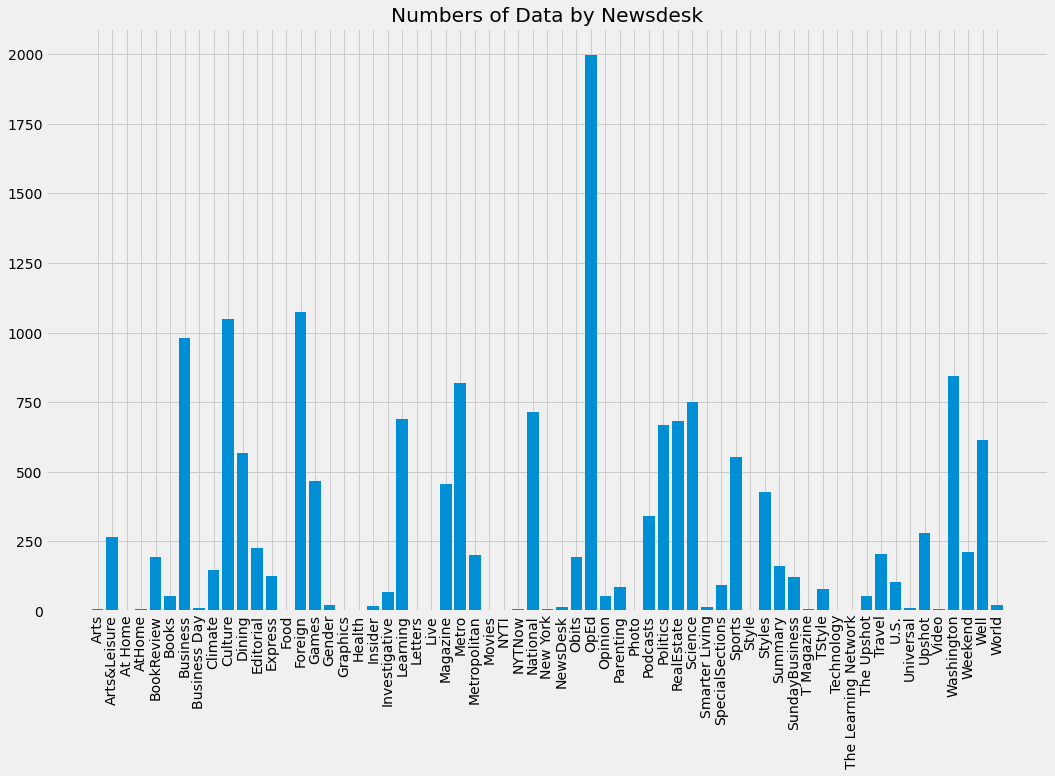

In [14]:
plt.figure(figsize=(16, 10))
plt.bar(np.arange(len(newsdesk)), df_articles.groupby("newsdesk").count().section.values)
plt.xticks(np.arange(len(newsdesk)), newsdesk, rotation=90)
plt.title("Numbers of Data by Newsdesk")
plt.show()

Berdasarkan `newsdesk`, yang terbanyak adalah **OpEd**, kemudian **Foreign**, dan **Culture**.

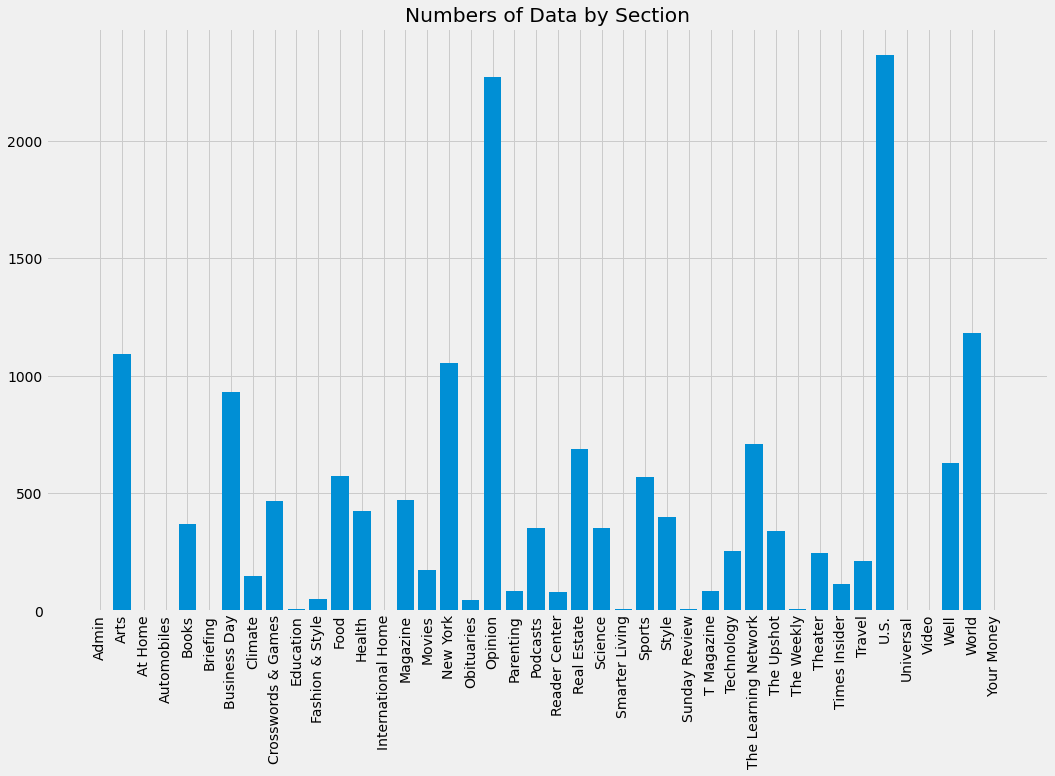

In [15]:
plt.figure(figsize=(16, 10))
plt.bar(np.arange(len(df_articles.groupby("section").count().index)), df_articles.groupby("section").count().newsdesk.values)
plt.xticks(np.arange(len(df_articles.groupby("section").count().index)), df_articles.groupby("section").count().index, rotation=90)
plt.title("Numbers of Data by Section")
plt.show()

Berdasarkan `section`, yang terbanyak adalah **U.S.**, kemudian **Opinion**, dan **World**.

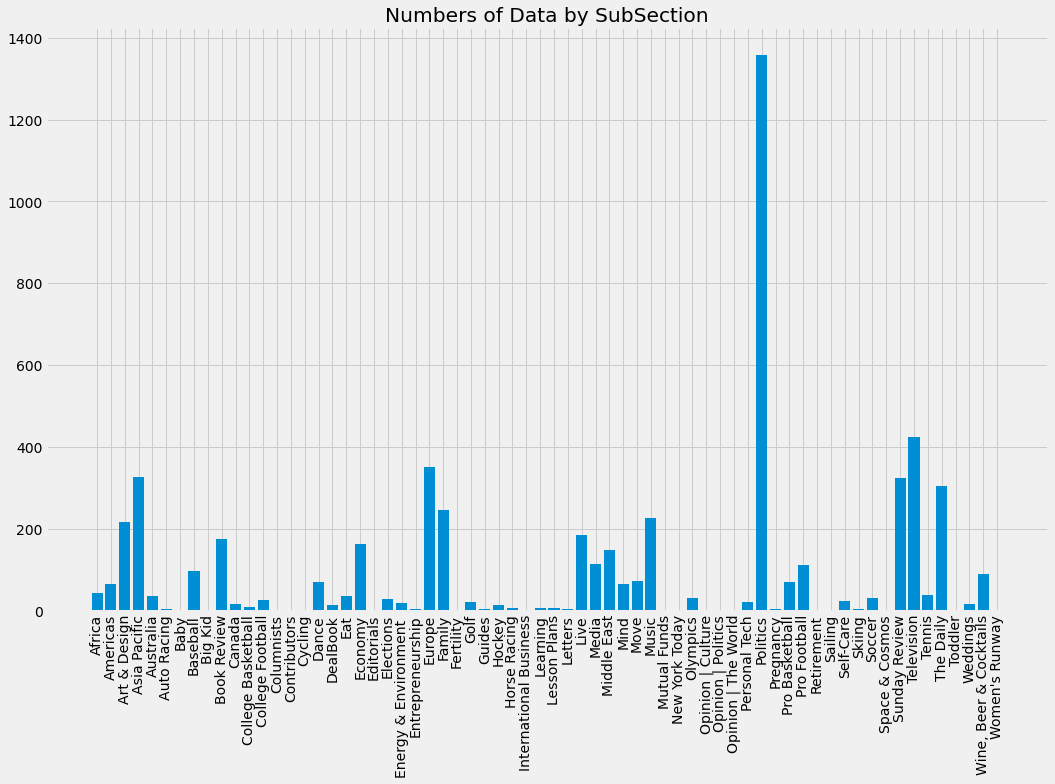

In [16]:
plt.figure(figsize=(16, 10))
plt.bar(np.arange(len(df_articles.groupby("subsection").count().index)), df_articles.groupby("subsection").count().section.values)
plt.xticks(np.arange(len(df_articles.groupby("subsection").count().index)), df_articles.groupby("subsection").count().index, rotation=90)
plt.title("Numbers of Data by SubSection")
plt.show()

In [17]:
df_articles[df_articles["subsection"].isna()]

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...
...,...,...,...,...,...,...,...,...,...,...,...
16778,RealEstate,Real Estate,NaN,News,"Homes for Sale in Brooklyn, Manhattan and Stat...",This week’s properties are in Downtown Brookly...,"['Real Estate and Housing (Residential)', 'Dow...",130,2020-12-31 14:00:24+00:00,50,nyt://article/6798b89f-8926-5e39-9d72-aa5f03eb...
16781,Science,Health,NaN,News,Here’s Why Distribution of the Vaccine Is Taki...,Health officials and hospitals are struggling ...,"['Vaccination and Immunization', 'Coronavirus ...",1570,2020-12-31 15:26:56+00:00,1169,nyt://article/5320a2e9-d739-542a-a397-443c4323...
16782,Editorial,Opinion,NaN,Op-Ed,What It Takes to Heal From Covid-19,"Survivors can get better, but they need help.","['Chronic Condition (Health)', 'Coronavirus (2...",1002,2020-12-31 15:27:47+00:00,166,nyt://article/e8adbb75-a8b3-5a8c-886b-b9c1195f...
16784,Business,Business Day,NaN,News,"Their Finances Ravaged, Customers Fear Banks W...",Banks have the power to decide whether to let ...,"['Banking and Financial Institutions', 'Corona...",1429,2020-12-31 16:21:40+00:00,556,nyt://article/c4b9edab-bdde-5d81-b496-06fedb52...


Berdasarkan `subsection`, yang terbanyak adalah **Politics**, kemudian **Television**, dan **Europe**. Namun sebenarnya terdapat **NaN** pada `subsection` sebanyak 11.094 data

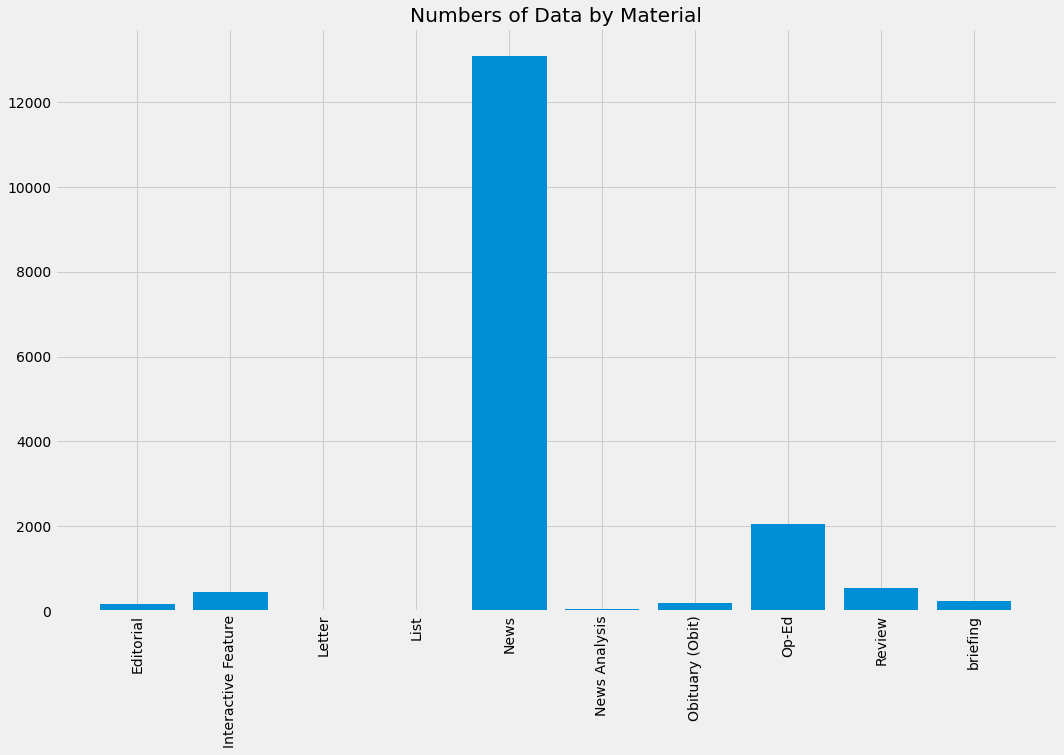

In [18]:
plt.figure(figsize=(16, 10))
plt.bar(np.arange(len(df_articles.groupby("material").count().index)), df_articles.groupby("material").count().section.values)
plt.xticks(np.arange(len(df_articles.groupby("material").count().index)), df_articles.groupby("material").count().index, rotation=90)
plt.title("Numbers of Data by Material")
plt.show()

Berdasarkan `material`, yang terbanyak adalah **News**, kemudian **Op-Ed**, dan **Review**.

Selanjutnya, kita ingin mengetahui untuk tiap bulannya, berita apa yang paling banyak mendapat reaksi berupa banyaknya komentar, data diperoleh dari kolom `n_comments`.

In [19]:
df_articles["pub_date"] = pd.to_datetime(df_articles["pub_date"].str.lstrip("0"))
df_articles

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...
...,...,...,...,...,...,...,...,...,...,...,...
16782,Editorial,Opinion,NaN,Op-Ed,What It Takes to Heal From Covid-19,"Survivors can get better, but they need help.","['Chronic Condition (Health)', 'Coronavirus (2...",1002,2020-12-31 15:27:47+00:00,166,nyt://article/e8adbb75-a8b3-5a8c-886b-b9c1195f...
16783,Sports,Sports,Baseball,News,Padres Jolt M.L.B. With Bold Moves to Set Up W...,While many teams continued to assess the finan...,"['San Diego Padres', 'Major League Baseball', ...",1100,2020-12-31 15:47:44+00:00,42,nyt://article/1f11417d-2c57-51b9-b75d-8f67f0a9...
16784,Business,Business Day,NaN,News,"Their Finances Ravaged, Customers Fear Banks W...",Banks have the power to decide whether to let ...,"['Banking and Financial Institutions', 'Corona...",1429,2020-12-31 16:21:40+00:00,556,nyt://article/c4b9edab-bdde-5d81-b496-06fedb52...
16785,Dining,Food,"Wine, Beer & Cocktails",News,Should Wine Be Among Your Health Resolutions?,The new category of ‘clean wines’ is an effort...,"['Wines', 'Grapes', 'Diet and Nutrition', 'Dia...",1307,2020-12-31 17:28:11+00:00,277,nyt://article/efcaf652-ffad-5b4e-9f17-4fd9aff5...


In [20]:
month = df_articles.loc[df_articles["pub_date"].dt.month==1]
top = month.loc[month["n_comments"] == month["n_comments"].max()]
print(top.headline.values)
print(top.abstract.values)
top

['U.S. Strike in Iraq Kills Qassim Suleimani, Commander of Iranian Forces']
['Suleimani was planning attacks on Americans across the region, leading to an airstrike in Baghdad, the Pentagon statement said. Iran’s supreme leader called for vengeance.']


,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
74,Washington,World,Middle East,News,"U.S. Strike in Iraq Kills Qassim Suleimani, Co...",Suleimani was planning attacks on Americans ac...,"['Iran', 'Suleimani, Qassim', 'Defense and Mil...",2333,2020-01-03 01:02:54+00:00,4595,nyt://article/4974c21a-f80b-5d19-96e4-fed6eb0a...


In [21]:
month = df_articles.loc[df_articles["pub_date"].dt.month==6]
top = month.loc[month["n_comments"] == month["n_comments"].max()]
print(top.headline.values)
print(top.abstract.values)
top

['Tear Gas Clears Path for Trump to Visit Church']
['Police officers used flash grenades to disperse a crowd so the president could visit for a photo opportunity. And in New York, protesters and looters defied a curfew.']


,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
7630,National,U.S.,NaN,News,Tear Gas Clears Path for Trump to Visit Church,Police officers used flash grenades to dispers...,"['Police Brutality, Misconduct and Shootings',...",3787,2020-06-01 09:13:44+00:00,4486,nyt://article/b316ddae-bf03-5de8-b9e6-a796d047...


In [22]:
month = df_articles.loc[df_articles["pub_date"].dt.month==12]
top = month.loc[month["n_comments"] == month["n_comments"].max()]
print(top.headline.values)
print(top.abstract.values)
top

['Why Prosecuting Trump Is a Very Bad Idea']
['The goal would be to renew faith in our government, but its effect would be the opposite.']


,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
15594,OpEd,Opinion,NaN,Op-Ed,Why Prosecuting Trump Is a Very Bad Idea,The goal would be to renew faith in our govern...,"['United States Politics and Government', 'Pre...",984,2020-12-03 10:00:12+00:00,4760,nyt://article/7e29ac1e-fd93-5e9f-ab32-55ef8947...


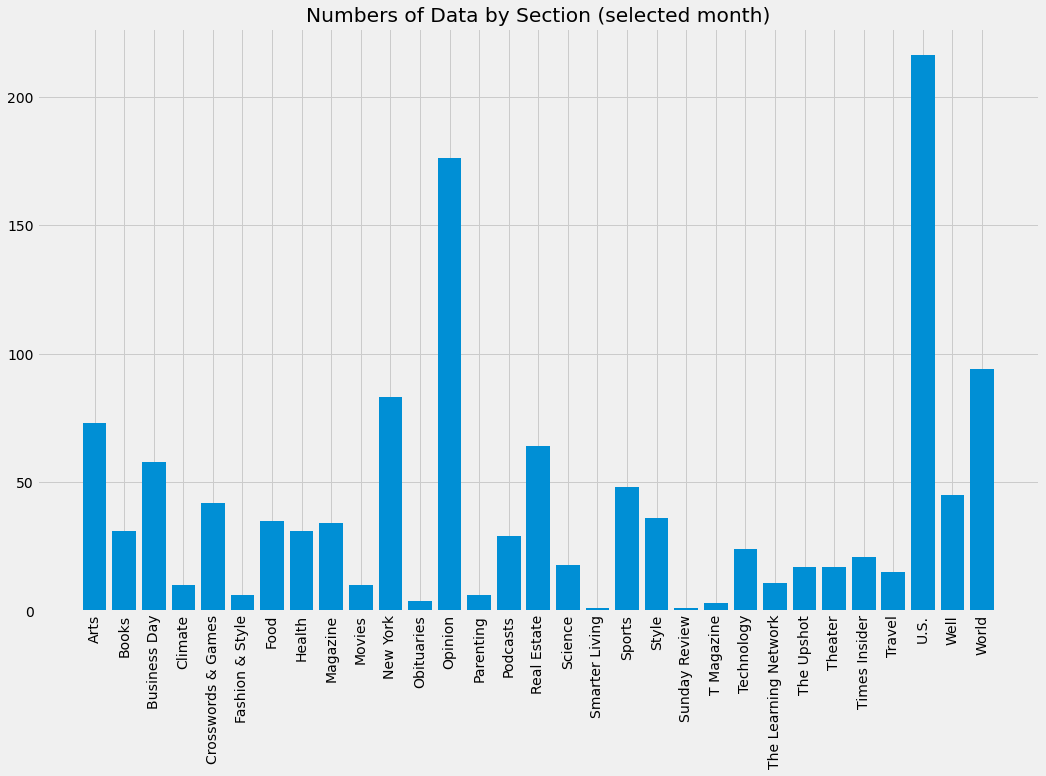

In [23]:
month = df_articles.loc[df_articles["pub_date"].dt.month==8]

plt.figure(figsize=(16, 10))
plt.bar(np.arange(len(month.groupby("section").count().index)), month.groupby("section").count().newsdesk.values)
plt.xticks(np.arange(len(month.groupby("section").count().index)), month.groupby("section").count().index, rotation=90)
plt.title("Numbers of Data by Section (selected month)")
plt.show()

Dapat dilihat mayoritas berita yang diupload adalah tentang Politik U.S. dan juga opini yang juga berkaitan dengan politik U.S. Hal ini karena pada tahun tersebut adalah waktu Pemilu presiden U.S. dan juga pada awal tahun berita banyak berkaitan dengan penyebaran virus COVID-19

## Data Preparation


Sebelum kita melakukan modelling, kita perlu merapikan dan membersihkan data. Dalam project kali ini, akan menggunakan data categorical sebagai fitur yang akan diolah dalam model. Yang termasuk data categorical adalah kolom `"newsdesk", "section", "subsection", "material"`. Kemudian tabel-tabel tersebut akan dijadikan numerical dengan menggunakan library `OneHotEncoder` melalui `ColumnTransformer`.

In [24]:
df_data = df_articles[["newsdesk", "section", "subsection", "material", "word_count", "n_comments"]]
df_data

,newsdesk,section,subsection,material,word_count,n_comments
0,Editorial,Opinion,NaN,Editorial,680,186
1,Games,Crosswords & Games,NaN,News,931,257
2,Science,Science,NaN,News,1057,6
3,Science,Science,NaN,Interactive Feature,0,2
4,Science,Science,NaN,News,1156,25
...,...,...,...,...,...,...
16782,Editorial,Opinion,NaN,Op-Ed,1002,166
16783,Sports,Sports,Baseball,News,1100,42
16784,Business,Business Day,NaN,News,1429,556
16785,Dining,Food,"Wine, Beer & Cocktails",News,1307,277


In [25]:
categorical = ["newsdesk", "section", "subsection", "material"]

In [26]:
df_data.isna().any()

newsdesk      False
section       False
subsection     True
material      False
word_count    False
n_comments    False
dtype: bool

membuat function untuh melakukan one hot encoding pada data categorical menggunakan library `OneHotEncoder()` dan `ColumnTransformer()`. Proses ini dilakukan untuk mengubah beberapa kategori pada kolom `["newsdesk", "section", "subsection", "material"]` yang memiliki sejumlah kategori yang sama untuk beberapa data menjadi numerical sehingga dapat diolah menggunakan model. Kemudian melakukan `fit_tansform` pada data. Kemudian menjadikan data tersebut sebagai data frame baru.

In [27]:
encoder = OneHotEncoder(handle_unknown="ignore", dtype=int)

In [28]:
trf_categorical = encoder.fit_transform(df_data[categorical]).toarray()
trf_categorical = pd.DataFrame(trf_categorical, columns=encoder.get_feature_names_out())
trf_categorical = pd.concat([trf_categorical, df_data[["word_count", "n_comments"]]], axis=1)
trf_categorical

,newsdesk_Arts,newsdesk_Arts&Leisure,newsdesk_At Home,newsdesk_AtHome,newsdesk_BookReview,newsdesk_Books,newsdesk_Business,newsdesk_Business Day,newsdesk_Climate,newsdesk_Culture,newsdesk_Dining,newsdesk_Editorial,newsdesk_Express,newsdesk_Food,newsdesk_Foreign,newsdesk_Games,newsdesk_Gender,newsdesk_Graphics,newsdesk_Health,newsdesk_Insider,newsdesk_Investigative,newsdesk_Learning,newsdesk_Letters,newsdesk_Live,newsdesk_Magazine,newsdesk_Metro,newsdesk_Metropolitan,newsdesk_Movies,newsdesk_NYTI,newsdesk_NYTNow,newsdesk_National,newsdesk_New York,newsdesk_NewsDesk,newsdesk_Obits,newsdesk_OpEd,newsdesk_Opinion,newsdesk_Parenting,newsdesk_Photo,newsdesk_Podcasts,newsdesk_Politics,...,subsection_Move,subsection_Music,subsection_Mutual Funds,subsection_New York Today,subsection_Olympics,subsection_Opinion | Culture,subsection_Opinion | Politics,subsection_Opinion | The World,subsection_Personal Tech,subsection_Politics,subsection_Pregnancy,subsection_Pro Basketball,subsection_Pro Football,subsection_Retirement,subsection_Sailing,subsection_Self-Care,subsection_Skiing,subsection_Soccer,subsection_Space & Cosmos,subsection_Sunday Review,subsection_Television,subsection_Tennis,subsection_The Daily,subsection_Toddler,subsection_Weddings,"subsection_Wine, Beer & Cocktails",subsection_Women's Runway,subsection_nan,material_Editorial,material_Interactive Feature,material_Letter,material_List,material_News,material_News Analysis,material_Obituary (Obit),material_Op-Ed,material_Review,material_briefing,word_count,n_comments
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,680,186
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,931,257
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1057,6
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1156,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16782,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1002,166
16783,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1100,42
16784,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1429,556
16785,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1307,277


setelah dilakukan One Hot Encoding, diperoleh data frame baru sesuai dengan kategori-kategori yang ada. Nilai 1 menunjukkan bahwa data pada baris tersebut masuk ke dalam kategori yang bernilai 1

kemudian, agar pengulahan data lebih stabil dan nilai yang dihasilkan tidak terlalu bervariasi, data hasil encoding tadi kita standarisasi menggunakan function `StandardScaler()`

In [29]:
scaler = StandardScaler(with_mean=False)
scaled_categorical = pd.DataFrame(scaler.fit_transform(trf_categorical))
scaled_categorical.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.658247,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.112314,10.324155,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.719646,0.362296
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,6.087048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.112314,0.000000,0.000000,0.0,0.0,2.412884,0.0,0.0,0.0,0.0,0.0,0.985280,0.500592
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.112314,0.000000,0.000000,0.0,0.0,2.412884,0.0,0.0,0.0,0.0,0.0,1.118626,0.011687
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.112314,0.000000,6.184605,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.003896
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.112314,0.000000,0.000000,0.0,0.0,2.412884,0.0,0.0,0.0,0.0,0.0,1.223398,0.048696


Setelah kita melakukan standarisasi, kita akan melakukan peringkasan/pengurangan feature/dimensi pada data dengan menggunakan `PCA()`, kemudian kita akan memilih jumlah fitur hasil PCA berdasarkan nilai **explained variance-nya**

In [30]:
 def run_pca(data, n_components=None):
    pca = PCA(n_components, random_state=11)
    pc_data = pca.fit_transform(data)
    return pca, pc_data


def scree_plot(pca, annotate=True):
    n_components = len(pca.explained_variance_ratio_)
    var_ratio = pca.explained_variance_ratio_.round(2)
    var_ratio_cumsum = var_ratio.cumsum()

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.bar(range(n_components), var_ratio)
    ax.plot(range(n_components), var_ratio_cumsum, marker=".")
    if annotate:
        for component in range(n_components):
            ax.annotate(f"{var_ratio[component]*100}%", (component, var_ratio[component]), va="bottom", ha="center", fontsize=10)
        ax.yaxis.set_tick_params(width=0)
        ax.xaxis.set_tick_params(width=2, length=5)
    ax.set_xlabel("Principal Components")
    ax.set_ylabel("Variance Explained (%)")
    ax.set_title("Explained Variance per Components")
    plt.show()

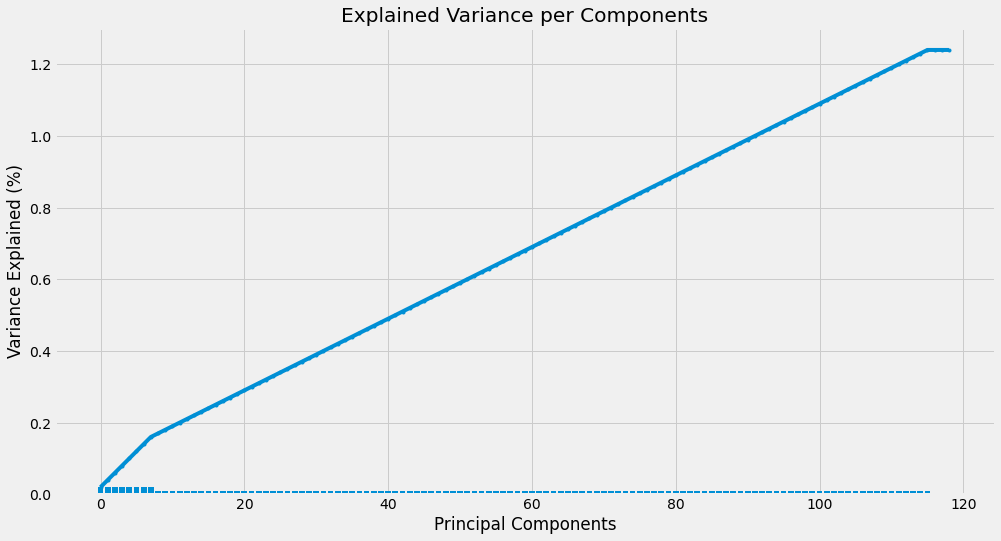

In [31]:
pca, pc_data = run_pca(scaled_categorical, n_components=119)
scree_plot(pca, annotate=False)

In [32]:
pca.explained_variance_ratio_.cumsum()

array([0.02416479, 0.04209535, 0.05973548, 0.07653315, 0.09284919,
       0.10906788, 0.12523274, 0.14119029, 0.15609781, 0.16951818,
       0.1825246 , 0.19526705, 0.20779086, 0.22010564, 0.23201601,
       0.24389051, 0.25550391, 0.26685796, 0.27815243, 0.2893806 ,
       0.30047771, 0.31142922, 0.322332  , 0.33322462, 0.34409945,
       0.35487121, 0.36495151, 0.37472565, 0.3843912 , 0.3933931 ,
       0.40236564, 0.41126075, 0.41956641, 0.42743944, 0.43506007,
       0.44237955, 0.4495484 , 0.45613878, 0.46269977, 0.46923267,
       0.47558414, 0.48181089, 0.48799311, 0.49414897, 0.50015821,
       0.50611663, 0.51205687, 0.51795312, 0.52375858, 0.52945958,
       0.53514122, 0.54078784, 0.54638359, 0.55194476, 0.55747475,
       0.56297774, 0.56847075, 0.57395328, 0.57942135, 0.58488749,
       0.59034984, 0.59580874, 0.60126644, 0.60672201, 0.61217677,
       0.61762736, 0.62307748, 0.62852677, 0.6339747 , 0.6394215 ,
       0.64486703, 0.65031099, 0.6557536 , 0.66119607, 0.66663

Berdasarkan hasil PCA, dapat dilihat, dengan cukup menggunakan componen sebanyak **119** dari 184 feature, kita sudah bisa memperoleh **90%** gambaran dari data. Sehingga untuk tahap modeling, kita akan menggunakan data 119 component hasil PCA

## Modelling

Untuk modeling, kita akan menggunakan unsupervised machine learning model yaitu `KMEANS Clustering`, `Hierarchical-based Clustering`, dan `DBSCAN`. Kemudian untuk evaluation metrics kita menggunakan `Elbow Method` untuk KMEANS, dan `silhouette score` untuk ketiga model tersebut.

### KMEANS Clustering

Yang pertama adalah **`KMEANS CLUSTERING`**. Kita akan mencari n_cluster dengan nilai silhouette score yang paling tinggi. Dan juga kita akan mencoba menggunakan n_cluster bedasarkan hasil evalusi Elbow Method

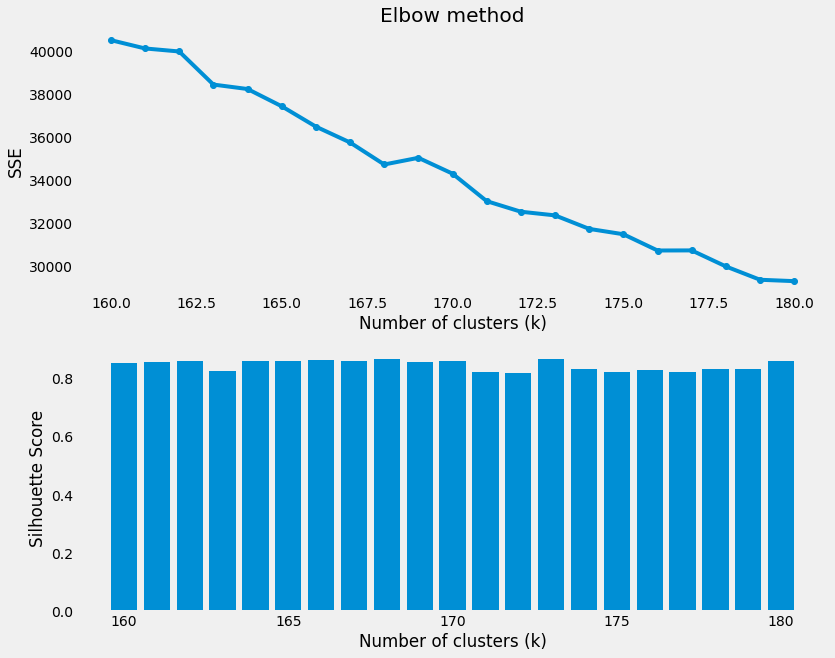

In [33]:
sse = {}
silhouette = {}
clusters = range(160, 181, 1)

for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=11)
    kmeans.fit(pc_data)
    sse[k] = kmeans.inertia_
    silhouette[k] = silhouette_score(pc_data, kmeans.predict(pc_data))

plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.plot(list(sse.keys()), list(sse.values()), "-o")
plt.title("Elbow method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.grid(False)

plt.subplot(212)
plt.bar(silhouette.keys(), silhouette.values())
# plt.title("Silhouette Scores for each number of clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(False)
plt.show()

In [34]:
print(silhouette)

{160: 0.8549333211551223, 161: 0.8591655096314497, 162: 0.8598607920807977, 163: 0.8278030584027399, 164: 0.8623284979493174, 165: 0.8614065065498159, 166: 0.8659826285772237, 167: 0.8594463117912386, 168: 0.8666127512945232, 169: 0.8570986952903357, 170: 0.8616873925827396, 171: 0.8242371107836138, 172: 0.8196457952699019, 173: 0.8685549953195085, 174: 0.8334929522879598, 175: 0.8228602372397236, 176: 0.8297187842226981, 177: 0.8238187036977423, 178: 0.8352944760235339, 179: 0.8330102568110326, 180: 0.8599713515174957}


In [35]:
# define kmeans model
kmeans_k168 = KMeans(n_clusters=168, random_state=11)
kmeans_k173 = KMeans(n_clusters=173, random_state=11)

# fit
kmeans_k168.fit(pc_data)
kmeans_k173.fit(pc_data)

# assign label columns
df_data["kmeans_k168_label"] = kmeans_k168.predict(pc_data)
df_data["kmeans_k173_label"] = kmeans_k173.predict(pc_data)

df_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,newsdesk,section,subsection,material,word_count,n_comments,kmeans_k168_label,kmeans_k173_label
0,Editorial,Opinion,NaN,Editorial,680,186,11,61
1,Games,Crosswords & Games,NaN,News,931,257,12,11
2,Science,Science,NaN,News,1057,6,47,36
3,Science,Science,NaN,Interactive Feature,0,2,47,36
4,Science,Science,NaN,News,1156,25,47,36
...,...,...,...,...,...,...,...,...
16782,Editorial,Opinion,NaN,Op-Ed,1002,166,147,147
16783,Sports,Sports,Baseball,News,1100,42,107,128
16784,Business,Business Day,NaN,News,1429,556,21,51
16785,Dining,Food,"Wine, Beer & Cocktails",News,1307,277,142,141


In [36]:
print(df_data["newsdesk"].nunique())
print(df_data["section"].nunique())
print(df_data["subsection"].nunique())
print(df_data["material"].nunique())

63
42
66
10


In [37]:
print(df_data["material"].unique())

['Editorial' 'News' 'Interactive Feature' 'Review' 'News Analysis'
 'Obituary (Obit)' 'Op-Ed' 'briefing' 'Letter' 'List']


In [38]:
mat = df_data[df_data["material"] == "News"]
print(mat.kmeans_k168_label.nunique(), mat.kmeans_k168_label.unique())
print(mat.kmeans_k173_label.nunique(), mat.kmeans_k173_label.unique())
mat

130 [ 12  47  48  22  71 159 160  16  74 158 161 121   3  13   2   9 134 108
   0  15 152  25  41  21   8 132  58  50  60  34  33  69 117 162 163   6
 127 133  45  44  36 110 129  84   4  30 156   7  24  32 142 130  56  19
  29 143  18 109   5  92 141 149 150  20  53  23  61 125 107  99  66  38
  87  62 111 128  42  55 120 166  90  40  72 144 154  89 119  83  54  81
  35  14 146  82 153  27  96 135  78  77 116  64  75  28  52  26  68 112
 123 114 151   1 122 106 113 104 148  73 145  39  49 124 100  17 140  86
  85  80 101  67]
130 [ 11  36 124 170  43   7 168   1  72 157 163 117  10  22   5  15   2  41
   0  17 158  28  37  51   8 152  86  16  27  29   4  58 122 151 150 130
 156 153  44  74  34  64  24  95   6  25 161  42 146  38 141 134 144  32
  13 164  79 148 111 138 143 165  33  49  21 118 125 128 102  45  69  81
  96 132 145  67 112  39 154  89  70  94  30  57  98  35  23  63  99 140
  18  48  80  55  14  90 131  93  66 127  68 100  54  53 142  88 119 133
 113 123  12 120 109 108 

,newsdesk,section,subsection,material,word_count,n_comments,kmeans_k168_label,kmeans_k173_label
1,Games,Crosswords & Games,NaN,News,931,257,12,11
2,Science,Science,NaN,News,1057,6,47,36
4,Science,Science,NaN,News,1156,25,47,36
5,Foreign,World,Middle East,News,1120,123,48,124
6,Magazine,Magazine,NaN,News,153,22,22,170
...,...,...,...,...,...,...,...,...
16781,Science,Health,NaN,News,1570,1169,25,28
16783,Sports,Sports,Baseball,News,1100,42,107,128
16784,Business,Business Day,NaN,News,1429,556,21,51
16785,Dining,Food,"Wine, Beer & Cocktails",News,1307,277,142,141


KMEANS with k=173 has better categorical than k=168 with higher `silhouette score 0.8685`

###Hierarchical-based Clustering

Selanjutnya menggunakan `AgglomerativeClustering()` dengan `linkage="ward"`

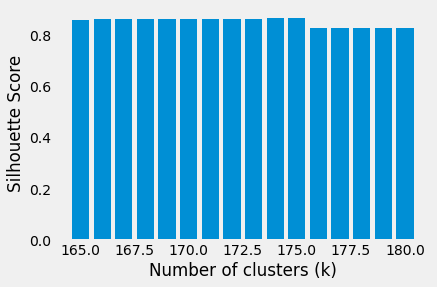

In [42]:
silhouette = {}
for k in range(165, 181, 1):
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = model.fit_predict(pc_data)
    silhouette[k] = silhouette_score(pc_data, labels)

plt.bar(silhouette.keys(), silhouette.values())
# plt.title("Silhouette Scores for each number of clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(False)
plt.show()

In [43]:
print(silhouette)

{165: 0.8594394451243759, 166: 0.8599958117169985, 167: 0.8603505571043952, 168: 0.8605748575507841, 169: 0.8624732842039499, 170: 0.8626071712831833, 171: 0.8627104872037843, 172: 0.863045149454811, 173: 0.863359353528227, 174: 0.8643437670782147, 175: 0.8650170467518357, 176: 0.8255069156033885, 177: 0.8263438041651484, 178: 0.8266665903251705, 179: 0.8276518024099776, 180: 0.8278635473814905}


In [44]:
model = AgglomerativeClustering(n_clusters=175, linkage="ward")
labels = model.fit_predict(pc_data)
average_silhouette_score = silhouette_score(
    pc_data, labels
)
print("ward linkage average_silhouette_score =", average_silhouette_score)

ward linkage average_silhouette_score = 0.8650170467518357


In [45]:
#define Agglomerative model
ward_175 = AgglomerativeClustering(n_clusters=175, linkage="ward")

#fit and asiign label
df_data["ward_175_label"] = ward_175.fit_predict(pc_data)

df_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,newsdesk,section,subsection,material,word_count,n_comments,kmeans_k168_label,kmeans_k173_label,ward_175_label
0,Editorial,Opinion,NaN,Editorial,680,186,11,61,72
1,Games,Crosswords & Games,NaN,News,931,257,12,11,143
2,Science,Science,NaN,News,1057,6,47,36,90
3,Science,Science,NaN,Interactive Feature,0,2,47,36,90
4,Science,Science,NaN,News,1156,25,47,36,90
...,...,...,...,...,...,...,...,...,...
16782,Editorial,Opinion,NaN,Op-Ed,1002,166,147,147,17
16783,Sports,Sports,Baseball,News,1100,42,107,128,5
16784,Business,Business Day,NaN,News,1429,556,21,51,97
16785,Dining,Food,"Wine, Beer & Cocktails",News,1307,277,142,141,67


**ward_175** menghasilkan kategori terbaik dengan `silhouette score = 0,8650`

###DBSCAN Clustering

Selanjutnya menggunakan Model `DBSCAN()`

In [46]:
epsilon = 3.5
min_samples = 3

silhouette = {}
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(pc_data)
silhouette_score(pc_data, labels)

0.8661673944929759

In [47]:
#define DSCAN model
dbscan = DBSCAN(eps=3.5, min_samples=3)

#fit and asiign label
df_data["dbscan_label"] = dbscan.fit_predict(pc_data)

df_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,newsdesk,section,subsection,material,word_count,n_comments,kmeans_k168_label,kmeans_k173_label,ward_175_label,dbscan_label
0,Editorial,Opinion,NaN,Editorial,680,186,11,61,72,0
1,Games,Crosswords & Games,NaN,News,931,257,12,11,143,1
2,Science,Science,NaN,News,1057,6,47,36,90,2
3,Science,Science,NaN,Interactive Feature,0,2,47,36,90,3
4,Science,Science,NaN,News,1156,25,47,36,90,2
...,...,...,...,...,...,...,...,...,...,...
16782,Editorial,Opinion,NaN,Op-Ed,1002,166,147,147,17,107
16783,Sports,Sports,Baseball,News,1100,42,107,128,5,99
16784,Business,Business Day,NaN,News,1429,556,21,51,97,30
16785,Dining,Food,"Wine, Beer & Cocktails",News,1307,277,142,141,67,68


In [48]:
df_data.dbscan_label.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  -1,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

dengan dbscan, model membagi kedalam `193` kategori, dan terdapat 1 kategori yang dihitung sebagai outlier. Silhouette score untuk DBSCAN dengan `epsilon=3.5` dan `min_sample=3` adalah `0.8661`

In [55]:
df_data.drop(columns="kmeans_k168_label", inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Kesimpulan

Berdasarkan nilai silhouette score yang terbaik (maksimum), model yang dipilih adalah **KMeans Clustering** dengan parameter `n_clusters=173`

In [61]:
df_data = pd.concat([df_data, df_articles[["headline", "abstract", "keywords"]]], axis=1)
df_data

,newsdesk,section,subsection,material,word_count,n_comments,kmeans_k173_label,ward_175_label,dbscan_label,headline,abstract,keywords
0,Editorial,Opinion,NaN,Editorial,680,186,61,72,0,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ..."
1,Games,Crosswords & Games,NaN,News,931,257,11,143,1,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles']
2,Science,Science,NaN,News,1057,6,36,90,2,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom..."
3,Science,Science,NaN,Interactive Feature,0,2,36,90,3,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S..."
4,Science,Science,NaN,News,1156,25,36,90,2,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',..."
...,...,...,...,...,...,...,...,...,...,...,...,...
16782,Editorial,Opinion,NaN,Op-Ed,1002,166,147,17,107,What It Takes to Heal From Covid-19,"Survivors can get better, but they need help.","['Chronic Condition (Health)', 'Coronavirus (2..."
16783,Sports,Sports,Baseball,News,1100,42,128,5,99,Padres Jolt M.L.B. With Bold Moves to Set Up W...,While many teams continued to assess the finan...,"['San Diego Padres', 'Major League Baseball', ..."
16784,Business,Business Day,NaN,News,1429,556,51,97,30,"Their Finances Ravaged, Customers Fear Banks W...",Banks have the power to decide whether to let ...,"['Banking and Financial Institutions', 'Corona..."
16785,Dining,Food,"Wine, Beer & Cocktails",News,1307,277,141,67,68,Should Wine Be Among Your Health Resolutions?,The new category of ‘clean wines’ is an effort...,"['Wines', 'Grapes', 'Diet and Nutrition', 'Dia..."


In [88]:
df_check = df_data.copy()
df_check.subsection.fillna("No Subsection", inplace=True)
df_check

,newsdesk,section,subsection,material,word_count,n_comments,kmeans_k173_label,ward_175_label,dbscan_label,headline,abstract,keywords
0,Editorial,Opinion,No Subsection,Editorial,680,186,61,72,0,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ..."
1,Games,Crosswords & Games,No Subsection,News,931,257,11,143,1,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles']
2,Science,Science,No Subsection,News,1057,6,36,90,2,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom..."
3,Science,Science,No Subsection,Interactive Feature,0,2,36,90,3,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S..."
4,Science,Science,No Subsection,News,1156,25,36,90,2,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',..."
...,...,...,...,...,...,...,...,...,...,...,...,...
16782,Editorial,Opinion,No Subsection,Op-Ed,1002,166,147,17,107,What It Takes to Heal From Covid-19,"Survivors can get better, but they need help.","['Chronic Condition (Health)', 'Coronavirus (2..."
16783,Sports,Sports,Baseball,News,1100,42,128,5,99,Padres Jolt M.L.B. With Bold Moves to Set Up W...,While many teams continued to assess the finan...,"['San Diego Padres', 'Major League Baseball', ..."
16784,Business,Business Day,No Subsection,News,1429,556,51,97,30,"Their Finances Ravaged, Customers Fear Banks W...",Banks have the power to decide whether to let ...,"['Banking and Financial Institutions', 'Corona..."
16785,Dining,Food,"Wine, Beer & Cocktails",News,1307,277,141,67,68,Should Wine Be Among Your Health Resolutions?,The new category of ‘clean wines’ is an effort...,"['Wines', 'Grapes', 'Diet and Nutrition', 'Dia..."


In [104]:
check = df_check[df_data["kmeans_k173_label"] == 0]
check

,newsdesk,section,subsection,material,word_count,n_comments,kmeans_k173_label,ward_175_label,dbscan_label,headline,abstract,keywords
36,Styles,Style,No Subsection,News,851,133,0,59,24,Thanks for the Piece of Plastic?,My friends gave me a gift card. When I tried t...,"['Customs, Etiquette and Manners']"
93,Styles,Style,No Subsection,News,2213,197,0,59,24,Hype House and the Los Angeles TikTok Mansion ...,The city is home to a land rush of “collab hou...,"['Social Media', 'TikTok (ByteDance)', 'Los An..."
189,Styles,Style,No Subsection,News,882,25,0,59,24,This Golden Globes Red Carpet Was Not Harvey W...,The 2020s may be the decade when awards show f...,"['Fashion and Apparel', 'Dresses', '#MeToo Mov..."
270,Styles,Style,No Subsection,News,703,14,0,59,24,"Donate $10 to Australia, Get a Nude Photo",Nude models are raising money for wildfire rel...,"['Social Media', 'Philanthropy', 'Fires and Fi..."
299,Styles,Style,No Subsection,News,1866,189,0,59,24,Real Men Don’t Rent,There’s only one problem as the growing clothi...,"['Fashion and Apparel', 'Rent the Runway', 'Me..."
...,...,...,...,...,...,...,...,...,...,...,...,...
16624,Styles,Style,No Subsection,News,1151,52,0,59,24,Some of Jackie O.’s Favorite Fabrics are Back ...,"In the late 1960s, Tillett Textiles teamed up ...","['Tillett Textiles', 'Bedford-Stuyvesant (Broo..."
16666,Styles,Style,No Subsection,News,1515,785,0,59,24,"Life Without Amazon (Well, Almost)","For concerned customers, avoiding one of the w...","['AMAZON.COM INC', 'Boycotts', 'E-Commerce', '..."
16738,Styles,Style,No Subsection,News,1036,7,0,59,24,Pierre Cardin: He Dressed Jane Jetson and Lady...,Some observations on the influential designer ...,"['Cardin, Pierre', 'Fashion and Apparel', 'Des..."
16756,Styles,Style,No Subsection,News,1515,57,0,59,24,Working From Bed Is Actually Great,A perfect metaphor for a year of giving up and...,"['Sleep', 'Quarantine (Life and Culture)', 'Te..."


['Styles' 'Summary']
['Style' 'U.S.']
['No Subsection']
['News' 'Review']


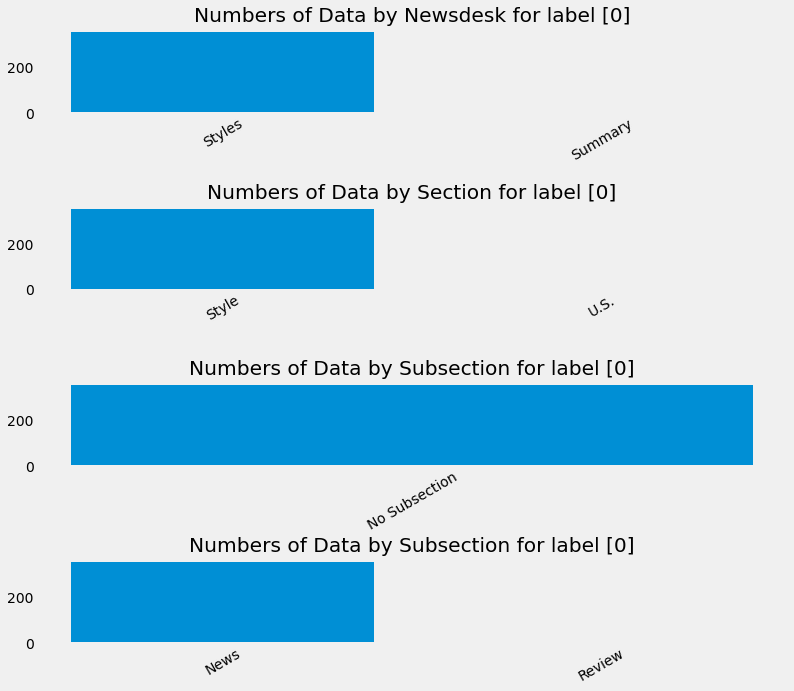

In [105]:
print(check.newsdesk.unique())
print(check.section.unique())
print(check.subsection.unique())
print(check.material.unique())

plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.bar(np.arange(len(check.groupby("newsdesk").count().index)), check.groupby("newsdesk").count().section.values)
plt.xticks(np.arange(len(check.groupby("newsdesk").count().index)), check.groupby("newsdesk").count().index, rotation=30)
plt.title("Numbers of Data by Newsdesk for label {}".format(check.kmeans_k173_label.unique()))
plt.grid(False)
plt.tight_layout(pad=3.0)

plt.subplot(412)
plt.bar(np.arange(len(check.groupby("section").count().index)), check.groupby("section").count().newsdesk.values)
plt.xticks(np.arange(len(check.groupby("section").count().index)), check.groupby("section").count().index, rotation=30)
plt.title("Numbers of Data by Section for label {}".format(check.kmeans_k173_label.unique()))
plt.grid(False)

plt.subplot(413)
plt.bar(np.arange(len(check.groupby("subsection").count().index)), check.groupby("subsection").count().newsdesk.values)
plt.xticks(np.arange(len(check.groupby("subsection").count().index)), check.groupby("subsection").count().index, rotation=30)
plt.title("Numbers of Data by Subsection for label {}".format(check.kmeans_k173_label.unique()))
plt.grid(False)

plt.subplot(414)
plt.bar(np.arange(len(check.groupby("material").count().index)), check.groupby("material").count().newsdesk.values)
plt.xticks(np.arange(len(check.groupby("material").count().index)), check.groupby("material").count().index, rotation=30)
plt.title("Numbers of Data by Subsection for label {}".format(check.kmeans_k173_label.unique()))
plt.grid(False)
plt.show()

Sebenarnya untuk hasil kategori menggunakan **DSCAN**, hasil kluster terlihat lebih jelas dan detail, namun untuk berapa kategori yang memiliki `sample < 3` maka dianggap sebagai `data outlier` dan tidak memiliki kategori. Terdapat 229 data yang termasuk dalam outlier.

In [103]:
check = df_check[df_data["dbscan_label"] == -1]
check

,newsdesk,section,subsection,material,word_count,n_comments,kmeans_k173_label,ward_175_label,dbscan_label,headline,abstract,keywords
99,Foreign,World,Middle East,briefing,3750,1884,124,10,-1,The Killing of Gen. Qassim Suleimani: What We ...,"Iran’s supreme leader, Ayatollah Ali Khamenei,...","['United States International Relations', 'Sul..."
114,Obits,Arts,Art & Design,Obituary (Obit),914,15,23,7,-1,"Syd Mead, 86, Maker of Future Worlds in ‘Blade...","In a wide-ranging career, he designed cars, re...","['Mead, Syd', 'Deaths (Obituaries)', 'Movies',..."
133,Washington,World,Americas,News Analysis,1267,1148,118,42,-1,"In Era of Perpetual Conflict, a Volatile Presi...",The killing of Maj. Gen. Qassim Suleimani is t...,"['Trump, Donald J', 'War and Emergency Powers ..."
138,Editorial,Opinion,Editorials,Editorial,1108,2214,91,27,-1,"Congress, Stop President Trump’s Rush to War W...",Republican senators are the only people with t...,"['Suleimani, Qassim', 'Defense and Military Fo..."
209,Arts&Leisure,Theater,No Subsection,Review,1335,15,157,148,-1,Reimagining Old Friends at the National Theate...,"New takes on beloved works by Elena Ferrante, ...","['Theater', 'Books and Literature', 'Royal Nat..."
...,...,...,...,...,...,...,...,...,...,...,...,...
16667,Parenting,Well,Live,News,1246,40,25,24,-1,"This Year, Try Downsizing Your Resolutions",2020 was a rough one. Here’s how to make goals...,"['New Year', 'Habits and Routines (Behavior)',..."
16669,SundayBusiness,Business Day,DealBook,News,373,42,102,84,-1,The Things Our Bosses Said a Lot This Year,"“You’re on mute” was said on 1,000 percent mor...","['Workplace Environment', 'Coronavirus (2019-n..."
16681,Obits,Style,No Subsection,Obituary (Obit),2703,170,23,7,-1,"Pierre Cardin, Designer to the Famous and Merc...",In a career spanning more than three-quarters ...,"['Cardin, Pierre', 'Fashion and Apparel', 'Des..."
16741,Express,World,Americas,News,852,10,118,42,-1,"The World Starts Saying Goodbye, at Long Last,...",The year that seemed to drag on forever is fin...,"['New Year', 'Quarantine (Life and Culture)', ..."


Karena penelitian digunakan untuk menentukan rekomendasi berita/konten, maka yang dipilih adalah hasil kategori dari **`KMeans Clustering`**. Pada KMeans clustering, berita dikategorikan berdasarkan kesamaan minimal **2 feature diantara 4 feature** yang ada `('newsdesk', 'section', 'subsection', 'materials')`. sehingga paling tidak, model dapat memberikan rekomendasi berita yang sama dalam tema/bahasannya sesuai preferensi pembaca.